# Data Exploration: Køge Dataset

This notebook contains the analysis of the signal data contained by the database provided by Jonas Munch Nielsen who is a PHD student.<br>

The Dataset is collected at childrens hospital of Boston. It contains EEG recordings 10 subjects. <br>
<br>
Notice that only files containing seizure timestamp are included.

The outline of this analysis is a follows: <br>

1. Reading and transforming the dataset to pandas Dataframe
2. Taking a look at the different features from the frequency and time domain.
3. Spectral analysis.
4. Building the model using the keras functional API.

## Importing Packages

In [1]:
# What version of Python do you have?
import sys
import os
import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import numpy as np
import re
import mne
import pathlib
import openpyxl
from datetime import datetime
import pytz
import matplotlib
import random
import os
from skimage.restoration import (denoise_wavelet, estimate_sigma)
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Sequential
from matplotlib import pyplot as plt
from scipy import signal
plt.ioff()
from time import gmtime
import psutil
import gc
import glob
plt.style.use('ggplot')

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.7.0
Keras Version: 2.7.0

Python 3.9.7 (default, Sep 16 2021, 23:53:23) 
[Clang 12.0.0 ]
Pandas 1.3.4
Scikit-Learn 1.0.1
GPU is available


## Data Overview

In [2]:
cwd = os.getcwd()
database_path = '../../Dataset/EMU_monitor(ruc)/'
save_csv_path = '../../Dataset/EMU_monitor(ruc)/NHR/EEG'
edf_file_type = ".edf"
capitilize_edf_file_type = ".EDF"
bdf_file_type = ".BDF"
patient_one_path = 'chb04/'
info_df_path = "/Users/niklashjort/Desktop/Notes/Speciale/projects/Dataset/EMU_monitor(ruc)/NHR_Eventlist_RUC.xlsx"
external_hardisk_drive_path = os.path.dirname('/Volumes/LaCie/Database/')
cwd

'/Users/niklashjort/Desktop/Notes/Speciale/projects/Master_Thesis_Project/Data_Analysis'

In [3]:
info_df = pd.read_excel(info_df_path, sheet_name="NHR_EEG")
info_df.head()

,patientID,time_emu,SeizureID,delay,seizureDuration,fileName
0,4,22-05-2019 02:45:22,1,83.000001,56,20190521155643_p4Nat2.sdeeg_converted_.easy_fi...
1,4,2019-05-22 03:50:49,2,83.000000,53,20190521155643_p4Nat2.sdeeg_converted_.easy_fi...
2,4,2019-05-22 05:27:56,3,81.000000,48,20190521155643_p4Nat2.sdeeg_converted_.easy_fi...
3,4,2019-05-22 07:07:04,4,81.000000,52,20190521155643_p4Nat2.sdeeg_converted_.easy_fi...
4,4,2019-05-22 07:51:24,5,81.000000,53,20190521155643_p4Nat2.sdeeg_converted_.easy_fi...


Find seizure duration distribution across all patients

In [4]:
patient_list = info_df['patientID'].unique()

distr_sz = {}

for patient in patient_list:
  duration = 0
  for _, row in info_df.iterrows():
    if str(patient) == str(row['patientID']):
      duration += row['seizureDuration']
  distr_sz[f"{patient}"] = duration

distr_sz
    

{'4': 503,
 '6': 146,
 '24': 106,
 '28': 70,
 '30': 350,
 '21': 1417,
 '33': 95,
 '34': 109,
 '35': 41}

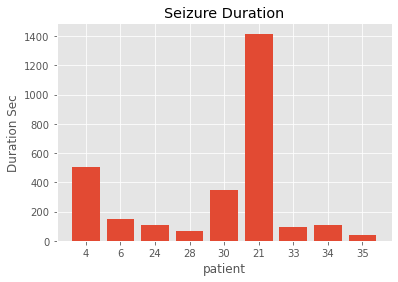

In [5]:
plt.bar(range(len(distr_sz)), list(distr_sz.values()), align="center")
plt.xticks(range(len(distr_sz)), list(distr_sz.keys()))
plt.title("Seizure Duration")
plt.xlabel('patient')
plt.ylabel('Duration Sec')
plt.show()

## Reading EEG DATA:

Sample: File information

In [6]:
def ReadEdfFile(file_name, print_reader_info = False):
    if edf_file_type in file_name or capitilize_edf_file_type in file_name:
        if(print_reader_info):
            data = mne.io.read_raw_edf(file_name)
            raw_data = data.get_data()
            converted_raw = pd.DataFrame(raw_data.transpose(), columns=data.ch_names)
            print(data.info)
            return converted_raw, data.info
        else:
            data = mne.io.read_raw_edf(file_name, verbose='error')
            raw_data = data.get_data()
            converted_raw = pd.DataFrame(raw_data.transpose(), columns=data.ch_names)
            return converted_raw, data.info
    if bdf_file_type in file_name:
        if(print_reader_info):
            data = mne.io.read_raw_bdf(file_name)
            raw_data = data.get_data()
            converted_raw = pd.DataFrame(raw_data.transpose(), columns=data.ch_names)
            print(data.info)
            return converted_raw, data.info
        else:
            data = mne.io.read_raw_edf(file_name, verbose='error')
            raw_data = data.get_data()
            converted_raw = pd.DataFrame(raw_data.transpose(), columns=data.ch_names)
            return converted_raw, data.info

Lets read a patient file containing one or more seizures.

In [172]:
eeg_df, info = ReadEdfFile("/Users/niklashjort/Desktop/Notes/Speciale/projects/Dataset/EMU_monitor(ruc)/EEG/Patient 4/20190522090132_p4dag3.sdeeg_converted_.easy_filtered.edf") 

Lets look at the mne info stored in the .EDF file by the EMU device.

In [8]:
info

<Info | 7 non-empty values
 bads: []
 ch_names: CH-1, CH-2, CH-3, CH-4, CH-5, CH-6, CH-7, CH-8, x, y, z
 chs: 11 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: 2019-05-22 09:01:32 UTC
 nchan: 11
 projs: []
 sfreq: 500.0 Hz
>

We know from this that: <br>
each channnel has been lowpass filtered from 250 Hz. <br>
The sampling rate is 500 Hz <br>
The timestamp for the first row is measurement date timestamp

In [167]:
EEG_FREQ = info['sfreq']
meas_timestamp = info['meas_date']

Now lets insert a timestamp column so we can define the seizure contained by the file.

In [10]:
eeg_df.head()

,CH-1,CH-2,CH-3,CH-4,CH-5,CH-6,CH-7,CH-8,x,y,z
0,-0.000006,-0.000007,-0.000005,-0.000005,-0.000016,-0.000002,-0.000016,0.000022,-2.079795e-08,5.039436e-08,4.938009e-09
1,-0.000009,-0.000008,-0.000009,-0.000009,-0.000018,-0.000004,-0.000020,0.000019,-2.079795e-08,5.039436e-08,4.938009e-09
2,0.000009,0.000010,0.000007,0.000008,-0.000002,0.000011,-0.000004,0.000034,-2.079795e-08,5.039436e-08,4.938009e-09
3,0.000007,0.000007,0.000006,0.000007,-0.000004,0.000011,-0.000006,0.000033,-2.079795e-08,5.039436e-08,4.938009e-09
4,0.000015,0.000015,0.000015,0.000015,0.000006,0.000021,0.000003,0.000042,-2.079795e-08,5.039436e-08,4.938009e-09


Only channel CH-1 and CH-2 is viable in this data. THe rest were simply not turned off during recording.

<Figure size 720x360 with 0 Axes>

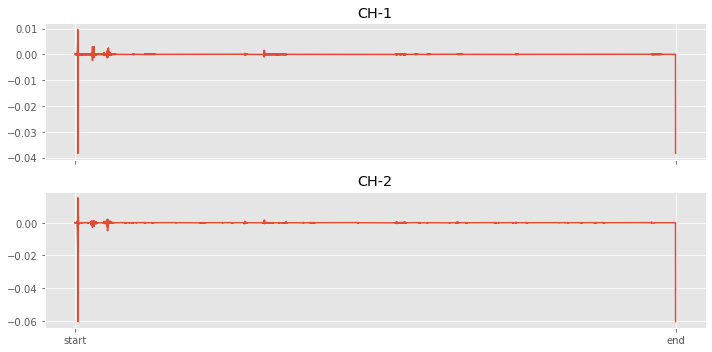

In [11]:
plt.figure(figsize=(10,5), facecolor='w')
fig, axs = plt.subplots(2, sharex=True, figsize=(10,5), facecolor='w')

axs[0].plot(eeg_df['CH-1'])
axs[0].set_title("CH-1")

axs[1].plot(eeg_df['CH-2'])
axs[1].set_title("CH-2")

my_x_ticks = ['start', "end"]
plt.xticks([0, len(eeg_df['CH-1'])], my_x_ticks)
fig.tight_layout()

plt.show()

As for the above. We can see that there exist some artefacts or rather events that affect the signal in start and end. <br>
We will remove these hopefully when applying filters <br>
To get the interval (time) for which the signal was recorded we can define a function as follows.

In [12]:
def convert_date_to_ms(date_time):
    date_time = str(date_time)
    if "+" in str(date_time):
        date_time = str(date_time).split("+")[0]
    try:
        timestamp_ms = datetime.utcnow().strptime(date_time, '%Y-%m-%d %H:%M:%S').timestamp() * 1000
    except:
        timestamp_ms = datetime.utcnow().strptime(date_time, '%d-%m-%Y %H:%M:%S').timestamp() * 1000
    return timestamp_ms

Lets convert info measurement timestamp to milliseconds

In [13]:
file_meas_start = convert_date_to_ms(meas_timestamp)
file_meas_start

1558508492000.0

We can convert it back to check.

In [14]:
datetime.fromtimestamp(file_meas_start/1000.0)

datetime.datetime(2019, 5, 22, 9, 1, 32)

So now we have the start row timestamp for all the channels. <br>
lets create a column which uses this, the index and the frequency to insert a timestamp column.

In [168]:
def insert_time_stamp(dataframe, file_start_time, frq, date_converter):
    timestamp_ms = date_converter(file_start_time)
    period_row_increment_value =  (1 / int(frq)) * 1000
    dataframe.insert(0, "timestamp", [timestamp_ms + i * period_row_increment_value for i in dataframe.index])

In [173]:
insert_time_stamp(eeg_df, info['meas_date'], info['sfreq'], convert_date_to_ms)


In [174]:
eeg_df.head()

,timestamp,CH-1,CH-2,CH-3,CH-4,CH-5,CH-6,CH-7,CH-8,x,y,z
0,1.558508e+12,-0.000006,-0.000007,-0.000005,-0.000005,-0.000016,-0.000002,-0.000016,0.000022,-2.079795e-08,5.039436e-08,4.938009e-09
1,1.558508e+12,-0.000009,-0.000008,-0.000009,-0.000009,-0.000018,-0.000004,-0.000020,0.000019,-2.079795e-08,5.039436e-08,4.938009e-09
2,1.558508e+12,0.000009,0.000010,0.000007,0.000008,-0.000002,0.000011,-0.000004,0.000034,-2.079795e-08,5.039436e-08,4.938009e-09
3,1.558508e+12,0.000007,0.000007,0.000006,0.000007,-0.000004,0.000011,-0.000006,0.000033,-2.079795e-08,5.039436e-08,4.938009e-09
4,1.558508e+12,0.000015,0.000015,0.000015,0.000015,0.000006,0.000021,0.000003,0.000042,-2.079795e-08,5.039436e-08,4.938009e-09


Now lets check the start-date and end-date of our file.

In [30]:
print("IN MS:")
print(eeg_df['timestamp'][0])
print(eeg_df['timestamp'].values[-1])

print("DATE:")
print(datetime.fromtimestamp(eeg_df['timestamp'][0]/1000.0))
print(datetime.fromtimestamp(eeg_df['timestamp'].values[-1]/1000))

IN MS:
1558508492000.0
1558515092998.0
DATE:
2019-05-22 09:01:32
2019-05-22 10:51:32.998000


## Filtering

For memory saving purposes i will only use a sample of the eeg data. The entire signal is filter in the "filter_edf_proj" project

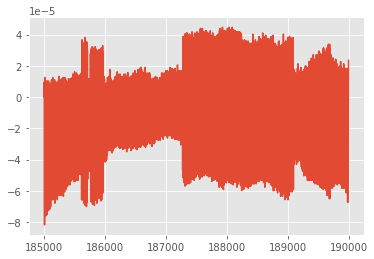

In [78]:
filt_sample = eeg_df['CH-1'][185000:190000]
filt_time = eeg_df['timestamp'][185000:190000]
plt.plot(filt_sample)
plt.show()

This is a good example since it contains some artefacts as we can see in the above.

I have applied the following filters:
1. low pass
2. high pass
3. bandpass
4. bandstop <br>

Each have their own unique purpose.

In [45]:
def rad_sample_to_hz(x, fs):
    return (x*fs)/(2*np.pi)

    
def plot_filter(b, a, fs, title=""):
    plt.figure(figsize=(20,5))
    w, h = signal.freqz(b, a, worN=256*2, whole=False)
    plt.plot(rad_sample_to_hz(w, fs), abs(h), linewidth=3)
    plt.ylabel('Gain', fontsize=18)
    plt.xlabel('Frequency', fontsize=18)

    if title != "":
        plt.title(title)
    plt.show()

### Low pass

In [31]:
def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    y = signal.filtfilt(b, a, data)
    return y

Plotting the filter. The essence of a low pass filter is that it squashes the signal where the frequency is higher than cutoff.

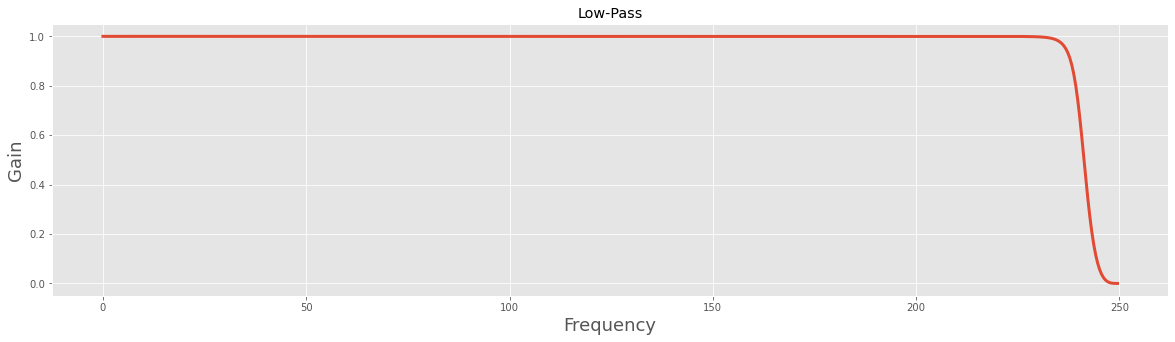

In [90]:
filter_order = 8
frequency_cutoff = 240
sampling_frequency = 500

b, a = signal.butter(4, frequency_cutoff, btype='low', analog=False, fs=sampling_frequency)
plot_filter(b, a, sampling_frequency, title="Low-Pass")


Filtered signal:

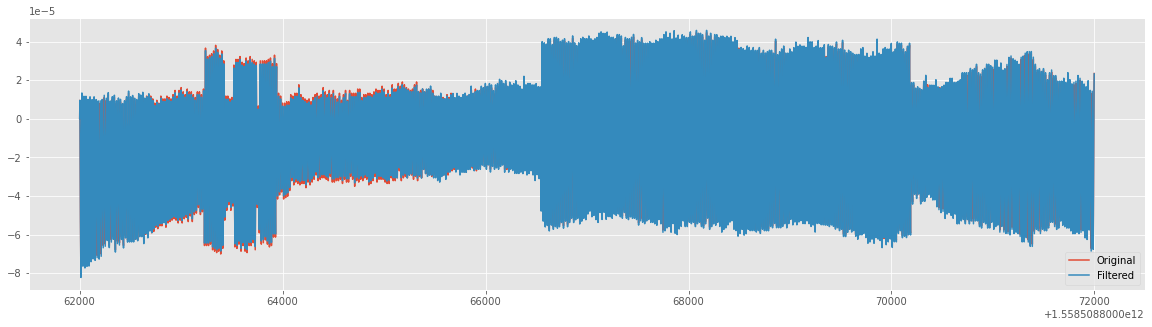

In [89]:
plt.figure(figsize=(20,5))
plt.plot(filt_time, filt_sample, label="Original")
plt.plot(filt_time, butter_lowpass_filter(filt_sample, 240, 500), label="Filtered")
plt.legend(loc='lower right')
plt.show()

It is hardly noticeable but it still reduce the noise in the signal. Espicially at high amplitudes.

## High Pass

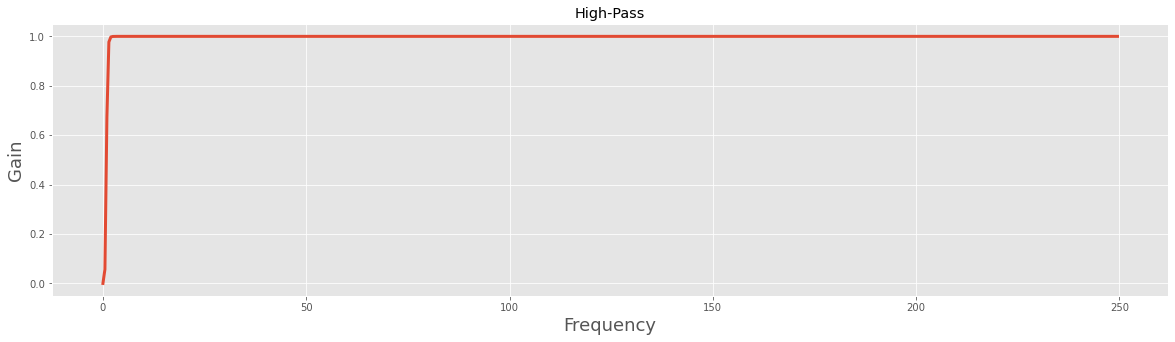

In [93]:
b, a = signal.butter(4, 1, btype='high', analog=False, fs=sampling_frequency)
plot_filter(b, a, sampling_frequency, title="High-Pass")

In [95]:
def butter_highpass_filter(data, cutoff, fs, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    y = signal.filtfilt(b, a, data)
    return y

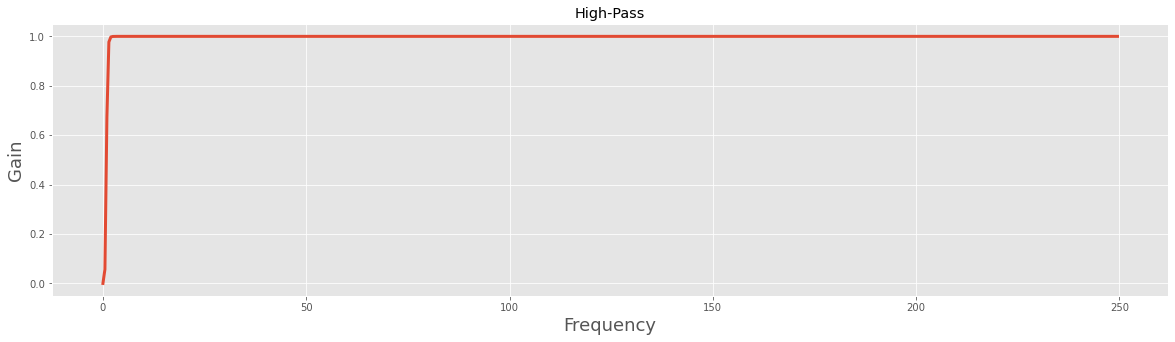

In [101]:
b, a = signal.butter(4, 1, btype='high', analog=False, fs=sampling_frequency)
plot_filter(b, a, sampling_frequency, title="High-Pass")

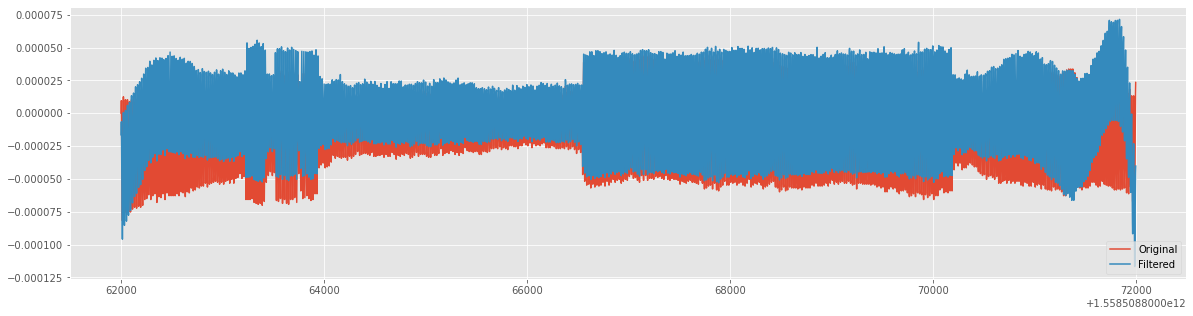

In [96]:
plt.figure(figsize=(20,5))
plt.plot(filt_time, filt_sample, label="Original")
plt.plot(filt_time, butter_highpass_filter(filt_sample, 1, 500), label="Filtered")
plt.legend(loc='lower right')
plt.show()

The highpass removes power baseline noise. Caused by the EMU device and other external devices.

## Bandpass filters

In [97]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order=1):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='bandpass')
    y = signal.filtfilt(b, a, data)
    return y

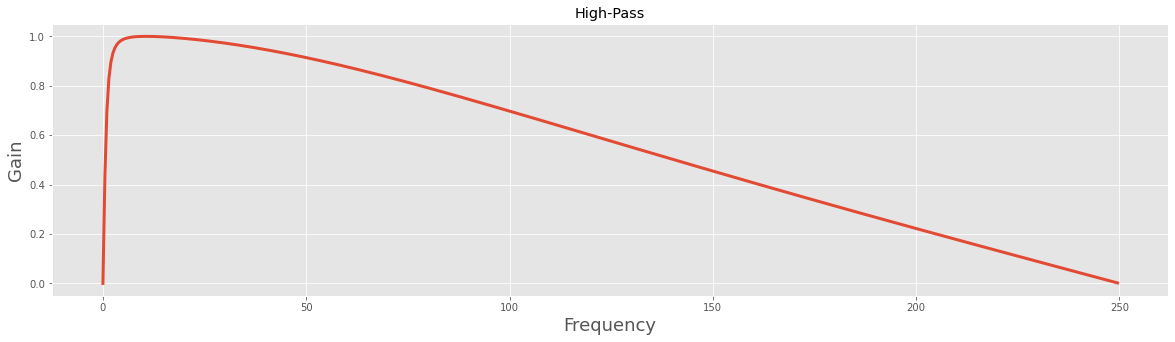

In [105]:
b, a = signal.butter(1, [1, 98], btype='bandpass', analog=False, fs=sampling_frequency)
plot_filter(b, a, sampling_frequency, title="High-Pass")

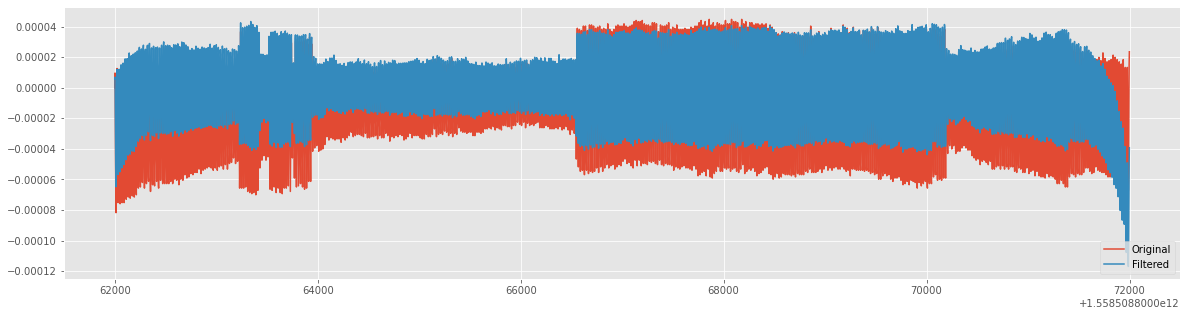

In [104]:
plt.figure(figsize=(20,5))
plt.plot(filt_time, filt_sample, label="Original")
plt.plot(filt_time, butter_bandpass_filter(filt_sample, 1, 98, 500, order=1), label="Filtered")
plt.legend(loc='lower right')
plt.show()

The bandpass filter is only implemented for increasing the impact of the frequencies of interrest which is f<98

## Bandstop filter

In [106]:
def butter_bandstop_filter(data, lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    i, u = signal.butter(order, [low, high], btype='bandstop')
    y = signal.lfilter(i, u, data)
    return y

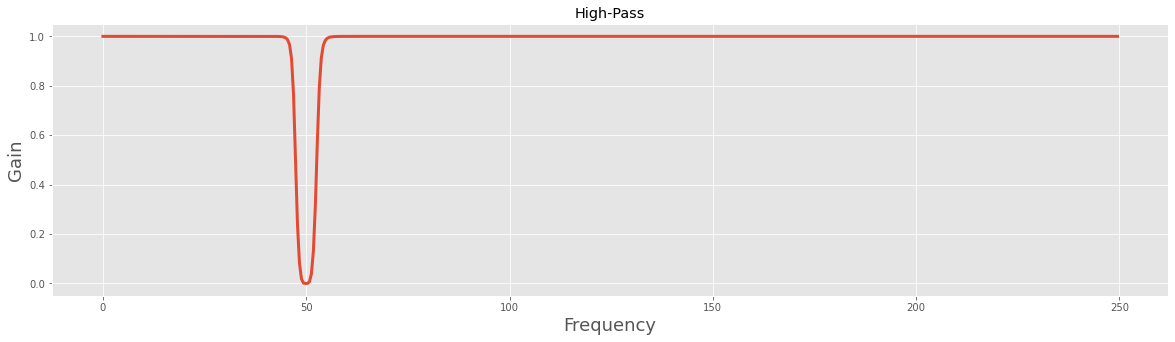

In [109]:
b, a = signal.butter(4, [47, 53], btype='bandstop', analog=False, fs=sampling_frequency)
plot_filter(b, a, sampling_frequency, title="High-Pass")

The bandstop filter is importnant for removing power line noise. This noise is usually coursed by the amplifier.

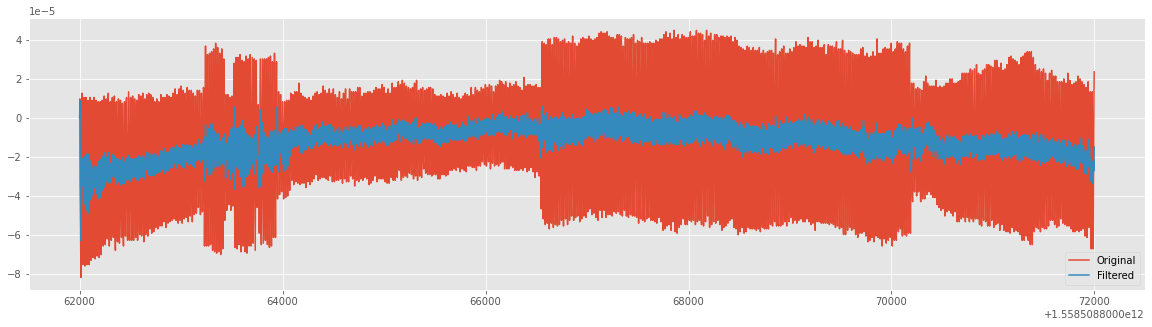

In [110]:
plt.figure(figsize=(20,5))
plt.plot(filt_time, filt_sample, label="Original")
plt.plot(filt_time, butter_bandstop_filter(filt_sample, 47, 53, 500, order=4), label="Filtered")
plt.legend(loc='lower right')
plt.show()

Conclussion: Power line noise is removed. As for the above we can see that it is heavily impacting the quality of our signal.

## All filters applied

In [111]:
def apply_filter(series, FREQ):
    series = butter_bandstop_filter(series, 97, 103, FREQ, order=4)
    series = butter_bandstop_filter(series, 47, 53, FREQ, order=4)
    series = butter_highpass_filter(series, 1, FREQ, order=4)
    series = butter_lowpass_filter(series, 240, FREQ, order=3)
    return series

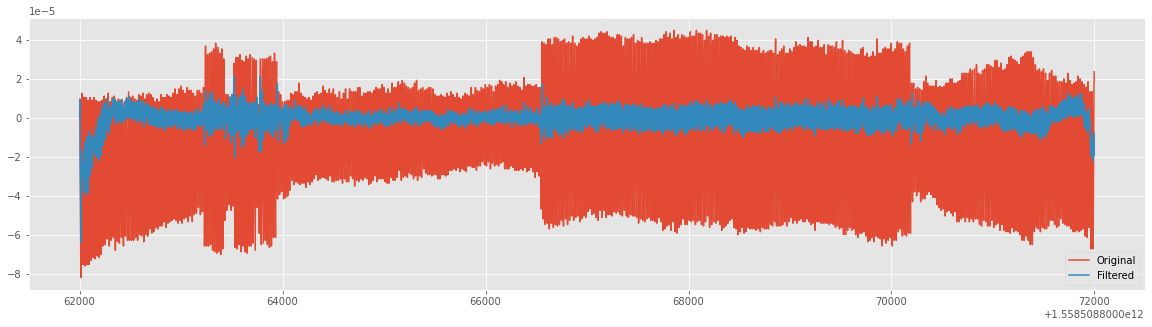

In [112]:
plt.figure(figsize=(20,5))
plt.plot(filt_time, filt_sample, label="Original")
plt.plot(filt_time, apply_filter(filt_sample, 500), label="Filtered")
plt.legend(loc='lower right')
plt.show()

### Seizure idenfication

Provided along the .edf file is an excel sheet. We can use the timestamp to extract the seizure.

In [131]:
def read_excel_to_df(path, sheet_name=None, sheet_mode=False):
    if sheet_mode:
        try:
            return pd.read_excel(path, sheet_name=sheet_name)
        except Exception as e:
            print(f"Read excel failed: {e}")
    return pd.read_excel(path)

In [133]:
info_df = read_excel_to_df(info_df_path, sheet_name="NHR_EEG", sheet_mode=True)
info_df.head()

,patientID,time_emu,SeizureID,delay,seizureDuration,fileName
0,4,22-05-2019 02:45:22,1,83.000001,56,20190521155643_p4Nat2.sdeeg_converted_.easy_fi...
1,4,2019-05-22 03:50:49,2,83.000000,53,20190521155643_p4Nat2.sdeeg_converted_.easy_fi...
2,4,2019-05-22 05:27:56,3,81.000000,48,20190521155643_p4Nat2.sdeeg_converted_.easy_fi...
3,4,2019-05-22 07:07:04,4,81.000000,52,20190521155643_p4Nat2.sdeeg_converted_.easy_fi...
4,4,2019-05-22 07:51:24,5,81.000000,53,20190521155643_p4Nat2.sdeeg_converted_.easy_fi...


Now we extract the first row that contains the sz info for the current file

In [158]:
row_of_interest = info_df[6:7]
print(row_of_interest)

   patientID             time_emu  SeizureID  delay  seizureDuration  \
6          4  2019-05-22 09:03:55          7   88.0               54   

                                            fileName  \
6  20190522090132_p4dag3.sdeeg_converted_.easy_fi...   

                                            fullPath  
6  ../../Dataset/EMU_monitor(ruc)/EEG/Patient 4/2...  


In [179]:
delay_ms = int(row_of_interest['delay'].iloc[0] * 1000)
duration_ms = int(row_of_interest['seizureDuration'].iloc[0] * 1000)
sz_start = convert_date_to_ms(row_of_interest['time_emu'].iloc[0]) + delay_ms
sz_end = sz_start + duration_ms

In [180]:
sz_df = eeg_df[(eeg_df['timestamp'] >= sz_start) & (eeg_df['timestamp'] < sz_end)]
print(f"len sz: {len(sz_df)}")

len sz: 27000


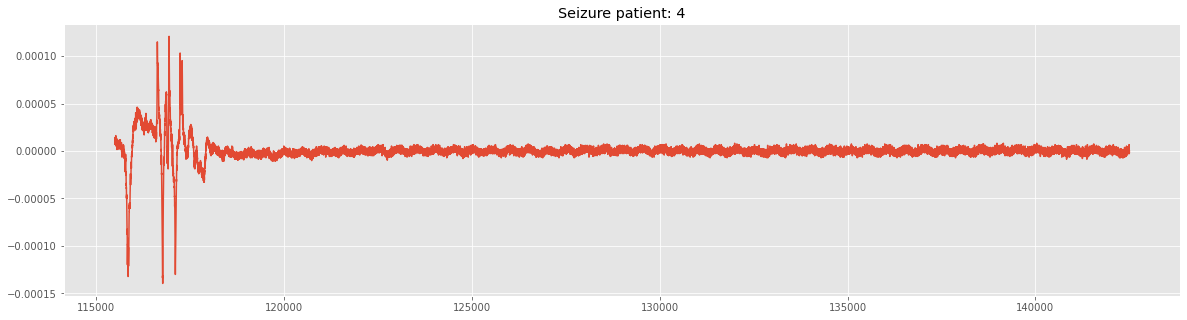

In [185]:
plt.figure(figsize=(20,5))
plt.plot(sz_df['CH-1'])
plt.title("Seizure patient: 4")
plt.show()

The other classes are extracted by the insert class function in "pandas_helper.py" (filter_edf_proj)

## Frequency analysis 

Lets try to look at the entire patient 4 CH-1 inside the frequency domain contra time domain.

In [116]:
f, Pxx_den = signal.periodogram(eeg_df['CH-1'], 500)

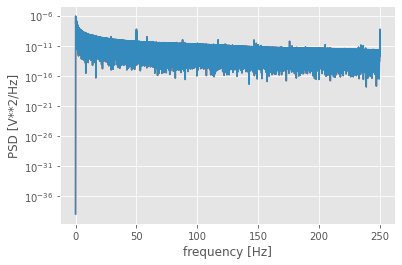

In [118]:
plt.semilogy(f, Pxx_den)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

<Figure size 720x504 with 0 Axes>

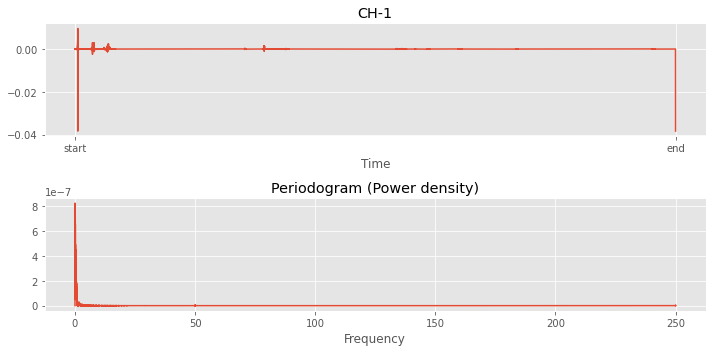

In [130]:
plt.figure(figsize=(10,7), facecolor='w')
fig, axs = plt.subplots(2, sharex=False, figsize=(10,5), facecolor='w')



axs[0].plot(eeg_df['CH-1'])
axs[0].set_title("CH-1")
axs[0].set_xlabel("Time")

axs[1].plot(f, Pxx_den)
axs[1].set_title("Periodogram (Power density)")
axs[1].set_xlabel("Frequency")

my_x_ticks = ['start', "end"]
axs[0].set_xticks([0, len(eeg_df['CH-1'])], my_x_ticks)
fig.tight_layout()

plt.show()

We can see from the above that the different artifacts in start/end is also present in the periodogram.

Lets try comparing the two using the filtered signal.

In [186]:
f_f, f_Pxx_den = signal.periodogram(apply_filter(eeg_df['CH-1'], 500), 500)

<Figure size 720x504 with 0 Axes>

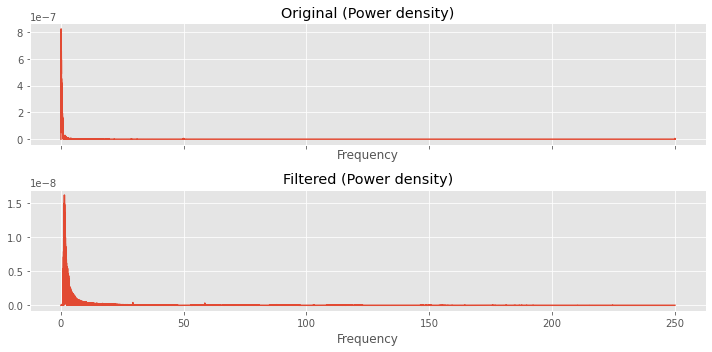

In [188]:
plt.figure(figsize=(10,7), facecolor='w')
fig, axs = plt.subplots(2, sharex=True, figsize=(10,5), facecolor='w')



axs[0].plot(f, Pxx_den)
axs[0].set_title("Original (Power density)")
axs[0].set_xlabel("Frequency")

axs[1].plot(f_f, f_Pxx_den)
axs[1].set_title("Filtered (Power density)")
axs[1].set_xlabel("Frequency")


fig.tight_layout()

plt.show()

Now we have a much "tighter" spectrum in power which is what we want.

Lets convert em both to a decibel scale to visualize the change in frequency better.

In [189]:
def nanpow2db(y):
    if isinstance(y, int) or isinstance(y, float):
        if y == 0:
            return np.nan
        else:
            ydB = 10 * np.log10(y)
    else:
        if isinstance(y, list):  # if list, turn into array
            y = np.asarray(y)
        y = y.astype(float)  # make sure it's a float array so we can put nans in it
        y[y == 0] = np.nan
        ydB = 10 * np.log10(y)

    return ydB

<Figure size 720x504 with 0 Axes>

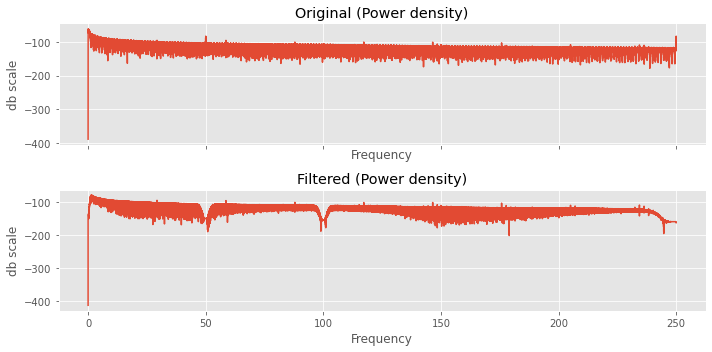

In [194]:
plt.figure(figsize=(10,7), facecolor='w')
fig, axs = plt.subplots(2, sharex=True, figsize=(10,5), facecolor='w')

axs[0].plot(f, nanpow2db(Pxx_den))
axs[0].set_title("Original (Power density)")
axs[0].set_xlabel("Frequency")
axs[0].set_ylabel("db scale")

axs[1].plot(f_f, nanpow2db(f_Pxx_den))
axs[1].set_title("Filtered (Power density)")
axs[1].set_xlabel("Frequency")
axs[1].set_ylabel("db scale")


fig.tight_layout()

plt.show()

Now we can see the result of out filters in the power of each individual frequnecy

### Welch

The power density analysis above is also containing the noise and the edge artefacts generated from filtering and remaining artefacts.  <br>

The Welch method can avoid this.

In [195]:
plt.figure(figsize=(10,7), facecolor='w')
f, Pxx_den = signal.welch(eeg_df["CH-1"], fs=500, window='hanning', detrend=False)
f, f_Pxx_den = signal.welch(apply_filter(eeg_df["CH-1"], 500), fs=500, window='hanning', detrend=False)

<Figure size 720x504 with 0 Axes>

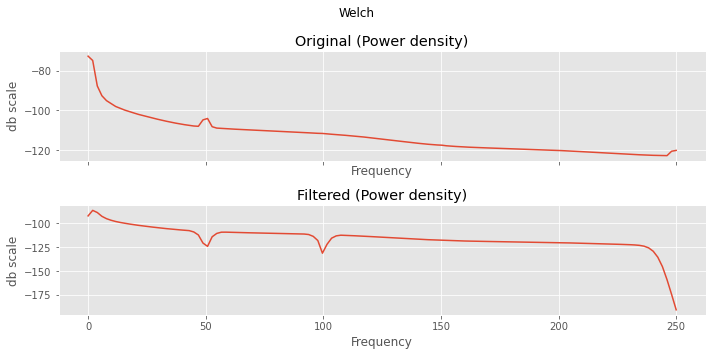

In [207]:
plt.figure(figsize=(10,7), facecolor='w')

fig, axs = plt.subplots(2, sharex=True, figsize=(10,5), facecolor='w')

axs[0].plot(f, nanpow2db(Pxx_den))
axs[0].set_title("Original (Power density)")
axs[0].set_xlabel("Frequency")
axs[0].set_ylabel("db scale")

axs[1].plot(f, nanpow2db(f_Pxx_den))
axs[1].set_title("Filtered (Power density)")
axs[1].set_xlabel("Frequency")
axs[1].set_ylabel("db scale")

fig.suptitle('Welch')
fig.tight_layout()

plt.show()

This is a much cleaner power spectrum

# Spectral Analysis

We will now split the data into segments of 4 seconds for further analysis.

Window function:

In [229]:
def get_window(channel, start_index, data, size = 4, overlap = 0, is_sezure = False, frequency = 500):
    if(is_sezure):
        overlap = 2
    else:
        overlap = overlap
    
    start = start_index * (size - overlap) * frequency
    end = start + (size * frequency)

    date_timestamp = ""


    date_timestamp = datetime.fromtimestamp((data['timestamp'][start:start+1]/1000).tolist()[0]).strftime('%H:%M:%S')
  

    print(f"Window: {start_index} Time: {date_timestamp}")
    
    return [data[channel][start:end].tolist(), date_timestamp]

In [209]:
def get_max_window_iteration(dataframe, buffer, FREQ = 500):
    len_of_df = int(len(dataframe) // (buffer*FREQ))
    return len_of_df

In [230]:
sz_win = [get_window(channel="CH-1",start_index=i, data=sz_df, is_sezure=True) for i in range(get_max_window_iteration(sz_df, 4))]

Window: 0 Time: 09:05:23
Window: 1 Time: 09:05:25
Window: 2 Time: 09:05:27
Window: 3 Time: 09:05:29
Window: 4 Time: 09:05:31
Window: 5 Time: 09:05:33
Window: 6 Time: 09:05:35
Window: 7 Time: 09:05:37
Window: 8 Time: 09:05:39
Window: 9 Time: 09:05:41
Window: 10 Time: 09:05:43
Window: 11 Time: 09:05:45
Window: 12 Time: 09:05:47


We have 12 windows now with an 2 second overlap. Let's plot one.

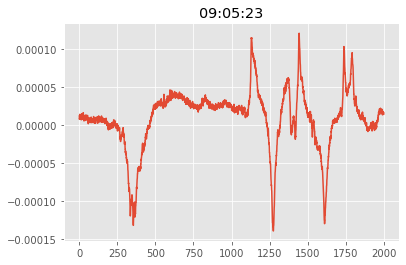

In [231]:
plt.plot(sz_win[0][0])
plt.title(sz_win[0][1])
plt.show()

500 Hz / 2000 samples = 4 sek window.

Lets look at the spectral spectrum

So the window function work. However if we plot again with a colorbar we notice that each spectrogram color density gets rescaled to the current STFT.

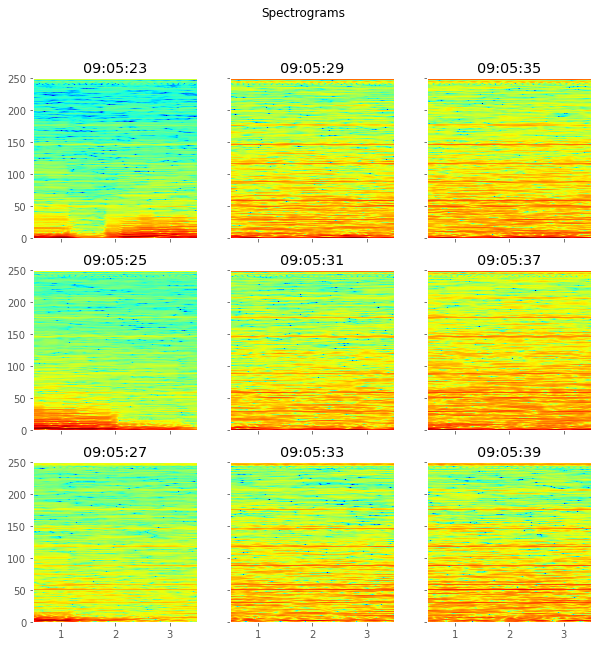

In [281]:
fig, axs = plt.subplots(3, 3, figsize=(10,10), sharey=True, sharex = True)
count = 0
for col in range(3):
  for row in range(3):
    ax = axs[row, col]
    ax.set_title(sz_win[count][1])
    f, t, Sxx = signal.spectrogram(np.array(sz_win[count][0]), fs=500, nperseg=500, noverlap=int(500*0.99), nfft=1024, scaling='density', return_onesided=True)
    ax.pcolormesh(t, f, nanpow2db(Sxx), cmap='jet')
    count += 1
fig.suptitle('Spectrograms')
plt.show()

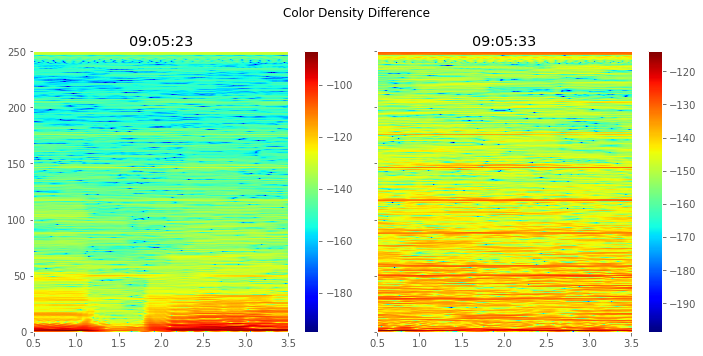

In [280]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5), sharey=True, sharex = True)

ax1.set_title(sz_win[0][1])
f, t, Sxx = signal.spectrogram(np.array(sz_win[0][0]), fs=500, nperseg=500, noverlap=int(500*0.99), nfft=1024, scaling='density', return_onesided=True)
pcm = ax1.pcolormesh(t, f, nanpow2db(Sxx), cmap='jet')

ax2.set_title(sz_win[5][1])
f, t, Sxx = signal.spectrogram(np.array(sz_win[5][0]), fs=500, nperseg=500, noverlap=int(500*0.99), nfft=1024, scaling='density', return_onesided=True)
pcm2 = ax2.pcolormesh(t, f, nanpow2db(Sxx), cmap='jet')

plt.colorbar(pcm, ax=ax1)
plt.colorbar(pcm2, ax=ax2)
fig.suptitle('Color Density Difference')
fig.tight_layout()
plt.show()